In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
import warnings
import joblib
import time
from concurrent.futures import ThreadPoolExecutor
import functools
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet
from skopt import BayesSearchCV
from skopt.space import Real, Integer

warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)

NUM_REALIZATIONS = 10
TARGET_NLL = -60

LOG_SLOPES = [1.0406028049510443, 0.0, 7.835345062351012]
LOG_OFFSETS = [-6.430669850650689, -2.1617411566043896, -45.24876794412965]

In [2]:
def load_data(train_path, test_path=None):
    train_df = pd.read_csv(train_path)
    
    train_ids = train_df['geology_id'].values
    
    input_cols = [str(i) for i in range(-49, 1)]
    
    output_cols = [str(i) for i in range(1, 301)]
    
    if test_path:
        test_df = pd.read_csv(test_path)
        test_ids = test_df['geology_id'].values
        
        return train_df, train_ids, input_cols, output_cols, test_df, test_ids
    
    return train_df, train_ids, input_cols, output_cols

def create_derived_features(X):
    n_samples, n_features = X.shape
    n_derived = 10
    derived_features = np.zeros((n_samples, n_derived))
    
    for i in range(n_samples):
        recent_points = X[i, -20:]
        x_vals = np.arange(-19, 1)
        
        full_series = X[i, :]
        
        valid_mask = ~np.isnan(recent_points) & ~np.isinf(recent_points)
        valid_points = recent_points[valid_mask]
        valid_x = x_vals[valid_mask]
        
        full_valid_mask = ~np.isnan(full_series) & ~np.isinf(full_series)
        full_valid = full_series[full_valid_mask]
        
        derived_features[i, :] = np.zeros(n_derived)
        
        try:
            if len(valid_points) >= 2:
                slope, intercept = np.polyfit(valid_x, valid_points, 1)
                derived_features[i, 0] = slope
            
            last_5_valid = X[i, -5:]
            last_5_valid = last_5_valid[~np.isnan(last_5_valid) & ~np.isinf(last_5_valid)]
            if len(last_5_valid) > 0:
                derived_features[i, 1] = np.mean(last_5_valid)
            
            if len(valid_points) > 1:
                derived_features[i, 2] = np.std(valid_points)
            else:
                derived_features[i, 2] = 0.01
            
            if len(valid_points) >= 3:
                coeffs = np.polyfit(valid_x, valid_points, 2)
                derived_features[i, 3] = coeffs[0]
            
            if len(valid_points) >= 10:
                first_valid = valid_points[0]
                last_valid = valid_points[-1]
                absolute_change = last_valid - first_valid
                if abs(first_valid) > 1e-6:
                    rel_change = absolute_change / abs(first_valid)
                    derived_features[i, 4] = np.clip(rel_change, -2.0, 2.0)
                else:
                    derived_features[i, 4] = np.clip(absolute_change, -2.0, 2.0)
            
            recent_valid = X[i, -5:]
            recent_valid = recent_valid[~np.isnan(recent_valid) & ~np.isinf(recent_valid)]
            
            prior_valid = X[i, -15:-5]
            prior_valid = prior_valid[~np.isnan(prior_valid) & ~np.isinf(prior_valid)]
            
            if len(recent_valid) > 0 and len(prior_valid) > 0:
                recent_mean = np.mean(recent_valid)
                prior_mean = np.mean(prior_valid)
                
                if abs(prior_mean) > 1e-6:
                    ratio = recent_mean / prior_mean
                    derived_features[i, 5] = np.tanh(ratio - 1)
            
            if len(valid_points) >= 10:
                seg_size = len(valid_points) // 3
                if seg_size >= 2:
                    seg1 = valid_points[:seg_size]
                    seg3 = valid_points[-seg_size:]
                    x1 = valid_x[:seg_size]
                    x3 = valid_x[-seg_size:]
                    
                    if len(seg1) >= 2 and len(seg3) >= 2:
                        slope1, _ = np.polyfit(x1, seg1, 1)
                        slope3, _ = np.polyfit(x3, seg3, 1)
                        
                        direction_product = slope1 * slope3
                        derived_features[i, 6] = 2.0 / (1.0 + np.exp(-3.0 * direction_product)) - 1.0
            
            if len(valid_points) >= 5:
                slope, intercept = np.polyfit(valid_x, valid_points, 1)
                trend_line = slope * valid_x + intercept
                residuals = valid_points - trend_line
                residual_var = np.var(residuals) if len(residuals) > 1 else 0
                total_var = np.var(valid_points) if len(valid_points) > 1 else 0
                
                if total_var > 1e-6:
                    trend_strength = 1 - (residual_var / total_var)
                    derived_features[i, 7] = trend_strength
                else:
                    derived_features[i, 7] = 0.0
            
            if len(valid_points) >= 15:
                small_scale = valid_points[-5:]
                small_x = valid_x[-5:]
                if len(small_scale) >= 2:
                    small_slope, _ = np.polyfit(small_x, small_scale, 1)
                    
                    large_slope, _ = np.polyfit(valid_x, valid_points, 1)
                    
                    scale_ratio = np.arctan2(small_slope, large_slope) / np.pi
                    derived_features[i, 8] = scale_ratio
            
            if len(valid_points) >= 5:
                centered = valid_points - np.mean(valid_points)
                
                if np.sum(centered**2) > 1e-6:
                    autocorr = np.correlate(centered[:-1], centered[1:], mode='valid')[0]
                    norm = np.sqrt(np.sum(centered[:-1]**2) * np.sum(centered[1:]**2))
                    
                    if norm > 1e-6:
                        derived_features[i, 9] = autocorr / norm
            
        except Exception as e:
            pass
    
    if np.isnan(derived_features).any() or np.isinf(derived_features).any():
        derived_features = np.nan_to_num(derived_features, nan=0.0, posinf=0.0, neginf=0.0)
    
    return derived_features

def prepare_data(train_df, input_cols, output_cols):
    X = train_df[input_cols].values
    y = train_df[output_cols].values

    imputer = KNNImputer(n_neighbors=5, weights='distance')
    X_imputed = imputer.fit_transform(X)
    
    if np.isnan(X_imputed).any() or np.isinf(X_imputed).any():
        X_imputed = np.nan_to_num(X_imputed, nan=0.0, posinf=0.0, neginf=0.0)
    
    derived_features = create_derived_features(X_imputed)
    
    X_enhanced = np.hstack((X_imputed, derived_features))
    
    X_train, X_val, y_train, y_val = train_test_split(X_enhanced, y, test_size=0.2, random_state=SEED)
    
    return X_train, X_val, y_train, y_val, derived_features.shape[1]

In [3]:
class StackingRegressor:
    def __init__(self, base_models, meta_model, n_folds=5, use_features_in_meta=False):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        self.use_features_in_meta = use_features_in_meta
        self.base_models_ = None
        self.meta_model_ = None
        
    def fit(self, X, y):
        from sklearn.model_selection import KFold
        from sklearn.base import clone
        
        self.base_models_ = [clone(model) for model in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=SEED)
        
        n_models = len(self.base_models)
        n_samples = X.shape[0]
        out_of_fold_preds = np.zeros((n_samples, n_models))
        
        for i, model in enumerate(self.base_models_):
            oof_pred = np.zeros(n_samples)
            
            for train_idx, valid_idx in kf.split(X):
                X_train_fold, X_valid_fold = X[train_idx], X[valid_idx]
                y_train_fold = y[train_idx]
                
                model.fit(X_train_fold, y_train_fold)
                
                oof_pred[valid_idx] = model.predict(X_valid_fold)
            
            out_of_fold_preds[:, i] = oof_pred
            
            model.fit(X, y)
        
        if self.use_features_in_meta:
            meta_features = np.hstack((out_of_fold_preds, X))
        else:
            meta_features = out_of_fold_preds
        
        self.meta_model_.fit(meta_features, y)
        
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([
            model.predict(X) for model in self.base_models_
        ])
        
        if self.use_features_in_meta:
            meta_features = np.hstack((meta_features, X))
        
        return self.meta_model_.predict(meta_features)

def optimize_hyperparameters(X, y, model_type, param_space, n_iter=15, cv=3):
    if model_type == 'xgb':
        model = xgb.XGBRegressor(random_state=SEED)
    elif model_type == 'lgb':
        model = lgb.LGBMRegressor(random_state=SEED)
    elif model_type == 'gbr':
        model = GradientBoostingRegressor(random_state=SEED)
    elif model_type == 'rf':
        model = RandomForestRegressor(random_state=SEED)
    else:
        raise ValueError(f"Tipo de modelo desconhecido: {model_type}")
    
    opt = BayesSearchCV(
        model,
        param_space,
        n_iter=n_iter,
        cv=cv,
        scoring='neg_mean_squared_error',
        random_state=SEED,
        n_jobs=-1 if model_type != 'xgb' else 1,
        verbose=0
    )
    
    opt.fit(X, y)
    
    return opt.best_params_

def train_model_for_position(pos_idx, X_train_processed, y_train, n_outputs, positions_params=None):
    pos = pos_idx + 1
    
    y_pos = y_train[:, pos_idx]
    
    model_performances = {}
    
    if pos <= 20:
        pos_group = 'early'
    elif pos <= 60:
        pos_group = 'mid_early'
    elif pos <= 200:
        pos_group = 'mid'
    else:
        pos_group = 'late'
    
    if positions_params and pos_group in positions_params:
        print(f"  Usando parâmetros pré-otimizados para grupo de posição: {pos_group}")
        param_set = positions_params[pos_group]
        xgb_params = param_set['xgb']
        lgb_params = param_set['lgb']
        gbr_params = param_set['gbr']
        rf_params = param_set['rf']
    else:
        print("  Usando parâmetros padrão (sem dados de otimização disponíveis)")
        
        xgb_params = {
            'n_estimators': 100,
            'max_depth': 4,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_weight': 1,
            'gamma': 0,
            'reg_alpha': 0,
            'reg_lambda': 1,
            'random_state': SEED
        }
        
        lgb_params = {
            'n_estimators': 100,
            'max_depth': 4,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_samples': 20,
            'reg_alpha': 0,
            'reg_lambda': 0,
            'random_state': SEED
        }
        
        gbr_params = {
            'n_estimators': 150,
            'max_depth': 4,
            'learning_rate': 0.05,
            'loss': 'squared_error',
            'subsample': 0.8,
            'random_state': SEED
        }
        
        rf_params = {
            'n_estimators': 100,
            'max_depth': 5,
            'min_samples_split': 5,
            'random_state': SEED
        }
    
    ridge_params = {
        'alpha': 1.0,
        'solver': 'auto',
        'random_state': SEED
    }
    
    elastic_params = {
        'alpha': 0.5,
        'l1_ratio': 0.5,
        'random_state': SEED,
        'max_iter': 1000
    }
    
    models_to_train = {
        'xgb': (xgb.XGBRegressor, xgb_params),
        'lgb': (lgb.LGBMRegressor, lgb_params),
        'gbr': (GradientBoostingRegressor, gbr_params),
        'rf': (RandomForestRegressor, rf_params),
        'ridge': (Ridge, ridge_params),
        'elastic': (ElasticNet, elastic_params)
    }
    
    for model_name, (model_class, params) in models_to_train.items():
        try:
            model = model_class(**params)
            model.fit(X_train_processed, y_pos)
            pred = model.predict(X_train_processed)
            mse = mean_squared_error(y_pos, pred)
            model_performances[model_name] = {'model': model, 'mse': mse}
        except Exception as e:
            print(f"  Erro ao treinar {model_name}: {e}")
    
    if len(model_performances) >= 3:
        try:
            base_models = [info['model'] for info in model_performances.values()]
            
            meta_learner = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=3)
            
            stack = StackingRegressor(
                base_models=base_models[:3],
                meta_model=meta_learner,
                n_folds=3,
                use_features_in_meta=False
            )
            
            stack.fit(X_train_processed, y_pos)
            stack_pred = stack.predict(X_train_processed)
            stack_mse = mean_squared_error(y_pos, stack_pred)
            model_performances['stack'] = {'model': stack, 'mse': stack_mse}
        except Exception as e:
            print(f"  Erro ao treinar modelo de Stacking: {e}")
    
    weights = {}
    total_inv_mse = 0
    inv_mse_weights = {}
    
    for model_name, info in model_performances.items():
        inv_mse = 1.0 / (info['mse'] + 1e-6)
        inv_mse_weights[model_name] = inv_mse
        total_inv_mse += inv_mse
    
    for model_name in inv_mse_weights:
        inv_mse_weights[model_name] /= total_inv_mse
    
    for model_name in model_performances:
        weights[model_name] = inv_mse_weights[model_name]
        
        if model_name == 'stack' and model_performances['stack']['mse'] < min(
            info['mse'] for name, info in model_performances.items() if name != 'stack'
        ):
            weights[model_name] *= 1.3
        
        if pos <= 20:
            if model_name in ['xgb', 'lgb', 'stack']:
                weights[model_name] *= 1.2
        elif pos <= 60:
            if model_name in ['xgb', 'lgb', 'gbr', 'stack']:
                weights[model_name] *= 1.1
        elif pos <= 200:
            pass
        else:
            if model_name in ['ridge', 'elastic', 'stack']:
                weights[model_name] *= 1.1
    
    total_weight = sum(weights.values())
    for model_name in weights:
        weights[model_name] /= total_weight
    
    model_data = {
        'models': {name: info['model'] for name, info in model_performances.items()},
        'weights': weights,
        'performances': {name: info['mse'] for name, info in model_performances.items()}
    }
    
    for model_name, info in model_performances.items():
        print(f"    {model_name}: MSE={info['mse']:.4f}, Peso={weights[model_name]:.2f}")
    
    return pos, model_data

In [4]:
def train_advanced_ensemble_models(X_train, y_train, n_derived_features, n_jobs=-1):
    n_outputs = y_train.shape[1]
    
    key_positions = []
    
    key_positions.extend(list(range(0, 60, 5)))
    key_positions.extend(list(range(60, 240, 20)))
    key_positions.extend(list(range(240, n_outputs, 10)))
    
    if key_positions[-1] != n_outputs - 1:
        key_positions.append(n_outputs - 1)
    
    models = {}
    
    scaler = StandardScaler()
    X_original = X_train[:, :-n_derived_features]
    X_derived = X_train[:, -n_derived_features:]
    
    X_original_scaled = scaler.fit_transform(X_original)
    
    X_train_processed = np.hstack((X_original_scaled, X_derived))
    
    positions_params = {}
    
    xgb_param_space = {
        'n_estimators': Integer(50, 150),
        'max_depth': Integer(3, 6),
        'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
        'subsample': Real(0.7, 1.0),
        'colsample_bytree': Real(0.7, 1.0),
        'min_child_weight': Integer(1, 5),
        'gamma': Real(0.0, 2.0),
        'reg_alpha': Real(0.0, 1.0),
        'reg_lambda': Real(0.5, 2.0)
    }
    
    lgb_param_space = {
        'n_estimators': Integer(50, 150),
        'max_depth': Integer(3, 6),
        'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
        'subsample': Real(0.7, 1.0),
        'colsample_bytree': Real(0.7, 1.0),
        'min_child_samples': Integer(10, 30),
        'reg_alpha': Real(0.0, 1.0),
        'reg_lambda': Real(0.5, 2.0)
    }
    
    gbr_param_space = {
        'n_estimators': Integer(50, 150),
        'max_depth': Integer(3, 6),
        'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
        'subsample': Real(0.7, 1.0)
    }
    
    rf_param_space = {
        'n_estimators': Integer(50, 150),
        'max_depth': Integer(3, 7),
        'min_samples_split': Integer(2, 8)
    }
    
    rep_positions = [10, 40, 120, 250]
    position_groups = ['early', 'mid_early', 'mid', 'late']
    
    for rep_pos, pos_group in zip(rep_positions, position_groups):
        y_pos = y_train[:, rep_pos]
        
        xgb_best_params = optimize_hyperparameters(X_train_processed, y_pos, 'xgb', xgb_param_space, n_iter=10)
        lgb_best_params = optimize_hyperparameters(X_train_processed, y_pos, 'lgb', lgb_param_space, n_iter=10)
        gbr_best_params = optimize_hyperparameters(X_train_processed, y_pos, 'gbr', gbr_param_space, n_iter=10)
        rf_best_params = optimize_hyperparameters(X_train_processed, y_pos, 'rf', rf_param_space, n_iter=10)
        
        xgb_best_params['random_state'] = SEED
        lgb_best_params['random_state'] = SEED
        gbr_best_params['random_state'] = SEED
        rf_best_params['random_state'] = SEED
        
        positions_params[pos_group] = {
            'xgb': xgb_best_params,
            'lgb': lgb_best_params,
            'gbr': gbr_best_params,
            'rf': rf_best_params
        }
        
    joblib.dump(positions_params, 'position_params.pkl')
    
    train_func = functools.partial(
        train_model_for_position,
        X_train_processed=X_train_processed,
        y_train=y_train,
        n_outputs=n_outputs,
        positions_params=positions_params
    )
    
    if n_jobs != 1:
        with ThreadPoolExecutor(max_workers=n_jobs if n_jobs > 0 else None) as executor:
            results = list(executor.map(train_func, key_positions))
        
        for pos, model_data in results:
            models[pos] = model_data
    else:
        for pos_idx in key_positions:
            pos, model_data = train_func(pos_idx)
            models[pos] = model_data
    
    return models, scaler, key_positions, n_derived_features

def predict_with_advanced_ensemble(X, models, scaler, key_positions, n_derived_features):
    n_samples = X.shape[0]
    n_outputs = 300
    
    X_original = X[:, :-n_derived_features]
    X_derived = X[:, -n_derived_features:]
    X_original_scaled = scaler.transform(X_original)
    X_processed = np.hstack((X_original_scaled, X_derived))
    
    predictions = np.zeros((n_samples, n_outputs))
    
    for pos in key_positions:
        model_pos = pos + 1
        model_info = models[model_pos]
        pos_idx = pos
        
        blended_preds = np.zeros(n_samples)
        
        model_dict = model_info['models']
        weight_dict = model_info['weights']
        
        for model_name, model in model_dict.items():
            try:
                preds = model.predict(X_processed)
                
                weight = weight_dict[model_name]
                blended_preds += weight * preds
            except Exception as e:
                print(f"Erro ao prever com {model_name} na posição {pos}: {e}")
        
        predictions[:, pos_idx] = blended_preds
    
    for i in range(n_samples):
        x_known = np.array(key_positions)
        y_known = predictions[i, key_positions]
        
        x_all = np.arange(n_outputs)
        
        if len(y_known) > 2:
            diffs = np.abs(np.diff(y_known))
            mean_diff = np.mean(diffs)
            max_diff = np.max(diffs)
            
            if max_diff > 5 * mean_diff:
                smoothing = 0.05
            elif max_diff > 2 * mean_diff:
                smoothing = 0.1
            else:
                smoothing = 0.15
        else:
            smoothing = 0.1
        
        try:
            if len(x_known) > 3:
                spline = UnivariateSpline(x_known, y_known, k=3, s=smoothing)
                predictions[i, :] = spline(x_all)
            else:
                predictions[i, :] = np.interp(x_all, x_known, y_known)
        except:
            predictions[i, :] = np.interp(x_all, x_known, y_known)
    
    for i in range(n_samples):
        try:
            recent_data = X_original[i, -15:]
            valid_mask = ~np.isnan(recent_data) & ~np.isinf(recent_data)
            
            if np.sum(valid_mask) >= 5:
                valid_recent = recent_data[valid_mask]
                valid_x = np.arange(len(recent_data))[valid_mask]
                
                recent_slope, _ = np.polyfit(valid_x, valid_recent, 1)
                
                pred_x = np.arange(50)
                pred_initial = predictions[i, :50]
                pred_slope, _ = np.polyfit(pred_x, pred_initial, 1)
                
                if recent_slope * pred_slope < 0 and abs(recent_slope) > 0.01:
                    correction_factor = 0.7
                    
                    distance = np.arange(n_outputs)
                    fade_out = np.exp(-distance / 100)
                    
                    correction = recent_slope * correction_factor * distance * fade_out
                    
                    predictions[i, :] += correction
        except Exception as e:
            pass
    
    return predictions

In [5]:
def calculate_inverse_covariance_vector():
    inverse_cov_vector = np.zeros(300)
    for x in range(1, 301):
        if 1 <= x <= 60:
            k = 0
        elif 61 <= x <= 244:
            k = 1
        else:
            k = 2
        
        inverse_cov_vector[x-1] = np.exp(np.log(x) * LOG_SLOPES[k] + LOG_OFFSETS[k])
    
    return inverse_cov_vector

def analyze_variance_structure(X_train, y_train, n_derived_features):
    X_train_original = X_train[:, :-n_derived_features]
    
    n_samples = X_train_original.shape[0]
    n_input_points = X_train_original.shape[1]
    n_output_points = y_train.shape[1]
    
    input_variance = np.var(X_train_original, axis=0)
    
    output_variance = np.var(y_train, axis=0)
    
    autocorr_dists = []
    
    for sample_idx in range(min(500, n_samples)):
        sample = X_train_original[sample_idx]
        
        if np.isnan(sample).any() or np.isinf(sample).any():
            continue
            
        try:
            corr = np.correlate(sample, sample, mode='full')
            
            corr = corr / np.max(corr)
            
            half_len = len(corr) // 2
            corr = corr[half_len+1:]
            
            half_corr_dist = np.argmax(corr < 0.5)
            if half_corr_dist > 0:
                autocorr_dists.append(half_corr_dist)
        except:
            continue
    
    if autocorr_dists:
        mean_autocorr_dist = np.mean(autocorr_dists)
    else:
        mean_autocorr_dist = 5.0
    
    inverse_cov_vector = calculate_inverse_covariance_vector()
    variance_scale_factors = 1.0 / np.sqrt(inverse_cov_vector)
    
    variance_scale_factors = variance_scale_factors / np.mean(variance_scale_factors)
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(range(-n_input_points, 0), input_variance, 'b-', label='Entrada')
    plt.plot(range(1, n_output_points + 1), output_variance, 'r-', label='Saída')
    plt.title('Variância por Posição')
    plt.xlabel('Posição')
    plt.ylabel('Variância')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.plot(range(1, 301), variance_scale_factors)
    plt.title('Fatores de Escala de Variância (baseados na métrica NLL)')
    plt.xlabel('Posição')
    plt.ylabel('Fator de Escala')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('analise_variancia.png')
    
    variance_params = {
        'input_variance': input_variance,
        'output_variance': output_variance,
        'mean_autocorr_dist': mean_autocorr_dist,
        'variance_scale_factors': variance_scale_factors
    }
    
    return variance_params

def calculate_nll_loss(y_true, predictions):
    n_samples = y_true.shape[0]
    num_realizations = predictions.shape[1]
    
    inverse_cov_vector = calculate_inverse_covariance_vector()
    
    losses = np.zeros(n_samples)
    
    p_i = 1.0 / num_realizations
    
    for i in range(n_samples):
        gaussian_misfits = np.zeros(num_realizations)
        
        for r in range(num_realizations):
            error_vector = y_true[i] - predictions[i, r]
            
            if np.isnan(error_vector).any() or np.isinf(error_vector).any():
                error_vector = np.nan_to_num(error_vector, nan=0.0, posinf=0.0, neginf=0.0)
            
            # E_i,G = exp(e_i(x) ⋅ D_T^{-1}(x) ⋅ e_i(x))
            weighted_error_sum = -np.sum(error_vector**2 * inverse_cov_vector)
            
            weighted_error_sum = np.clip(weighted_error_sum, -700, 700)
            
            gaussian_misfits[r] = np.exp(weighted_error_sum)
        
        sum_weighted_misfits = np.sum(p_i * gaussian_misfits)
        
        if sum_weighted_misfits > 1e-300:
            losses[i] = -np.log(sum_weighted_misfits)
        else:
            losses[i] = 700.0
    
    mean_loss = np.mean(losses)
    median_loss = np.median(losses)
    high_loss_count = np.sum(losses > 100)
    
    print(f"NLL: média={mean_loss:.2f}, mediana={median_loss:.2f}, amostras com NLL alto: {high_loss_count}/{n_samples}")
    
    return mean_loss

In [6]:
def generate_calibrated_realizations(X, base_predictions, variance_params, n_derived_features, num_realizations=10):
    X_original = X[:, :-n_derived_features]
    
    n_samples = X_original.shape[0]
    n_outputs = base_predictions.shape[1]
    all_realizations = np.zeros((n_samples, num_realizations, n_outputs))
    
    mean_autocorr_dist = variance_params['mean_autocorr_dist']
    variance_scale_factors = variance_params['variance_scale_factors']
    output_variance = variance_params['output_variance']
    
    global_variance_factor = 0.6
    
    all_realizations[:, 0, :] = base_predictions
    
    strategies = [
        ("alta_fidelidade", 0.8, mean_autocorr_dist * 0.8, None, 0.0),
        ("baixa_variancia", 0.6, mean_autocorr_dist * 1.2, None, 0.0),
        ("variancia_media", 0.9, mean_autocorr_dist * 0.7, None, 0.0),
        ("tendencia_ascendente", 0.8, mean_autocorr_dist, "upward", 0.8),
        ("tendencia_descendente", 0.8, mean_autocorr_dist, "downward", 0.8),
        ("tendencia_tardia_ascendente", 0.8, mean_autocorr_dist, "late_upward", 1.0),
        ("tendencia_tardia_descendente", 0.8, mean_autocorr_dist, "late_downward", 1.0),
        ("oscilacao_suave", 0.7, mean_autocorr_dist * 0.8, "oscillatory", 0.6),
        ("reversao_suave", 0.8, mean_autocorr_dist, "reversal", 0.7),
    ]
    
    for r in range(1, num_realizations):
        strategy_idx = min(r-1, len(strategies)-1)
        strategy_name, scale_base, corr_length, trend_type, trend_amplitude = strategies[strategy_idx]
        
        print(f"Gerando realização {r} com estratégia: {strategy_name}")
        
        for i in range(n_samples):
            realization = base_predictions[i].copy()
            
            try:
                last_points = X_original[i, -10:]
                valid_mask = ~np.isnan(last_points) & ~np.isinf(last_points)
                valid_last_points = last_points[valid_mask]
                
                if len(valid_last_points) > 0:
                    input_std = np.std(valid_last_points)
                else:
                    input_std = 0.1
            except:
                input_std = 0.1
            
            output_std_init = np.sqrt(np.mean(output_variance[:20]))
            
            base_std = (input_std + output_std_init) / 2
            
            base_std = max(base_std, 0.01)
            
            noise_scale = base_std * scale_base * global_variance_factor
            
            noise = np.random.normal(0, noise_scale, n_outputs)
            
            scaled_noise = noise * variance_scale_factors
            
            smooth_noise = gaussian_filter1d(scaled_noise, sigma=corr_length)
            
            if trend_type == "upward":
                trend_magnitude = base_std * trend_amplitude
                trend = np.linspace(0, trend_magnitude, n_outputs)
                smooth_noise += trend
                
            elif trend_type == "downward":
                trend_magnitude = base_std * trend_amplitude
                trend = np.linspace(trend_magnitude, 0, n_outputs)
                smooth_noise += trend
                
            elif trend_type == "late_upward":
                trend_magnitude = base_std * trend_amplitude
                x = np.linspace(0, 1, n_outputs)
                trend = trend_magnitude * (np.exp(2*x) - 1) / (np.exp(2) - 1)
                smooth_noise += trend
                
            elif trend_type == "late_downward":
                trend_magnitude = base_std * trend_amplitude
                x = np.linspace(0, 1, n_outputs)
                trend = trend_magnitude * (1 - (np.exp(2*x) - 1) / (np.exp(2) - 1))
                smooth_noise += trend
                
            elif trend_type == "oscillatory":
                n_cycles = 2 if "longa" in strategy_name else 3
                cycle_magnitude = base_std * trend_amplitude
                cycles = np.sin(np.linspace(0, n_cycles*np.pi, n_outputs)) * cycle_magnitude
                smooth_noise += cycles
                
            elif trend_type == "reversal":
                trend_magnitude = base_std * trend_amplitude
                x = np.linspace(0, 1, n_outputs)
                mid_point = n_outputs // 2
                trend = np.zeros(n_outputs)
                trend[:mid_point] = np.linspace(0, trend_magnitude, mid_point)
                trend[mid_point:] = np.linspace(trend_magnitude, -trend_magnitude, n_outputs - mid_point)
                smooth_noise += trend
            
            realization += smooth_noise
            
            try:
                last_valid_idx = -1
                while last_valid_idx >= -X_original.shape[1]:
                    last_point = X_original[i, last_valid_idx]
                    if not np.isnan(last_point) and not np.isinf(last_point):
                        break
                    last_valid_idx -= 1
                
                if last_valid_idx >= -X_original.shape[1]:
                    first_pred_point = realization[0]
                    offset = first_pred_point - last_point
                    realization -= offset
            except:
                pass
            
            if strategy_name in ["alta_fidelidade", "oscilacao_suave"]:
                try:
                    window_size = min(15, int(corr_length*2) + 1)
                    window_size = window_size + 1 if window_size % 2 == 0 else window_size
                    realization = savgol_filter(realization, window_length=window_size, polyorder=2)
                except:
                    pass
            
            if np.isnan(realization).any() or np.isinf(realization).any():
                realization = base_predictions[i].copy()
            
            all_realizations[i, r, :] = realization
    
    return all_realizations

def calibrate_nll_target(val_realizations, y_val, initial_value=0.6, target_nll=-60):
    scaled_realizations = val_realizations.copy()
    
    base_predictions = val_realizations[:, 0, :]
    
    def apply_segmented_scale(scale_factor):
        segments = [(0, 60), (60, 180), (180, 300)]
        segment_scales = [scale_factor * 0.95, scale_factor, scale_factor * 1.05]
        
        for r in range(1, scaled_realizations.shape[1]):
            for i in range(scaled_realizations.shape[0]):
                base = base_predictions[i]
                
                for (start, end), seg_scale in zip(segments, segment_scales):
                    diff = val_realizations[i, r, start:end] - base[start:end]
                    scaled_diff = diff * seg_scale
                    scaled_realizations[i, r, start:end] = base[start:end] + scaled_diff
        
        nll = calculate_nll_loss(y_val, scaled_realizations)
        return nll
    
    best_scale = initial_value
    best_nll = apply_segmented_scale(initial_value)
    print(f"NLL inicial com escala {initial_value}: {best_nll}")
    
    scales_to_try = []
    if best_nll < target_nll:
        scales_to_try = [0.5, 0.4, 0.3, 0.2]
    else:
        scales_to_try = [0.7, 0.8, 0.9, 1.0]
    
    for scale in scales_to_try:
        nll = apply_segmented_scale(scale)
        print(f"NLL com escala {scale}: {nll}")
        
        if abs(nll - target_nll) < abs(best_nll - target_nll):
            best_scale = scale
            best_nll = nll
    
    print(f"Melhor escala: {best_scale}, NLL resultante: {best_nll}")
    return best_scale, best_nll

In [7]:
def visualize_examples(X_val, y_val, val_realizations, n_derived_features, num_examples=3):
    X_val_original = X_val[:, :-n_derived_features]
    
    indices = np.random.choice(X_val_original.shape[0], num_examples, replace=False)
    
    plt.figure(figsize=(15, 12))
    for i, idx in enumerate(indices):
        plt.subplot(num_examples, 1, i+1)
        
        plt.plot(range(-49, 1), X_val_original[idx], 'b-', label='Dados Conhecidos')
        
        plt.plot(range(1, 301), y_val[idx], 'g-', label='Verdade')
        
        for r in range(val_realizations.shape[1]):
            if r == 0:
                plt.plot(range(1, 301), val_realizations[idx, r, :], 'r-', alpha=0.7, label='Previsão Base')
            else:
                plt.plot(range(1, 301), val_realizations[idx, r, :], 'r-', alpha=0.3)
        
        plt.axvline(x=0, color='k', linestyle='--')
        plt.title(f'Exemplo #{idx}')
        plt.xlabel('Posição X')
        plt.ylabel('Coordenada Z')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('predicoes_validacao.png')

def prepare_submission(test_ids, all_realizations, output_path):
    submission_dict = {'geology_id': test_ids}
    
    for i in range(300):
        submission_dict[str(i+1)] = all_realizations[:, 0, i]
    
    for r in range(1, all_realizations.shape[1]):
        for i in range(300):
            submission_dict[f'r_{r}_pos_{i+1}'] = all_realizations[:, r, i]
    
    submission_df = pd.DataFrame(submission_dict)
    submission_df.to_csv(output_path, index=False)
    print(f"Arquivo de submissão salvo em {output_path}")

INICIANDO PIPELINE DE PREDIÇÃO DE CAMADAS GEOLÓGICAS
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14411
[LightGBM] [Info] Number of data points in the train set: 805, number of used features: 59
[LightGBM] [Info] Start training from score 0.046380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

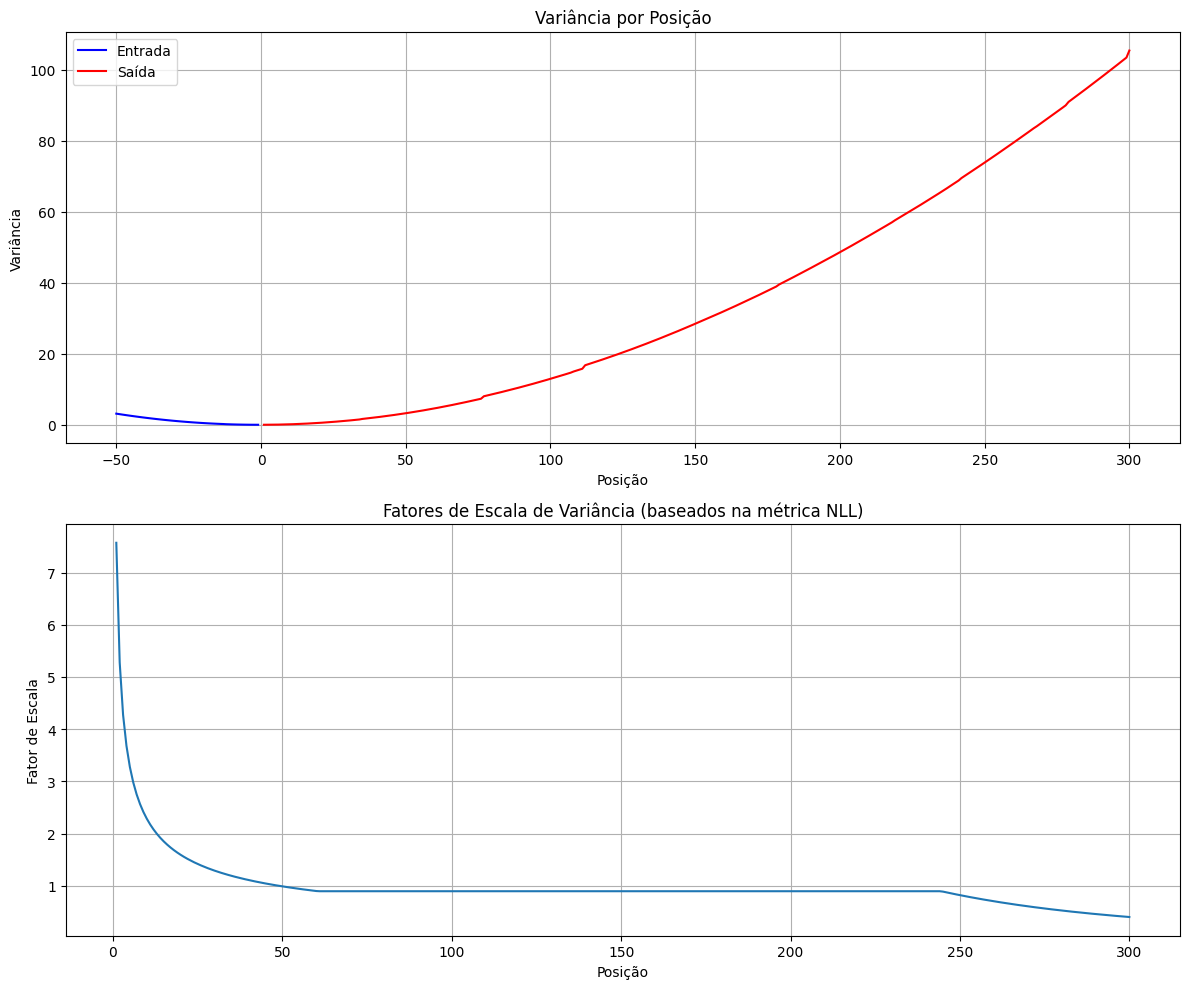

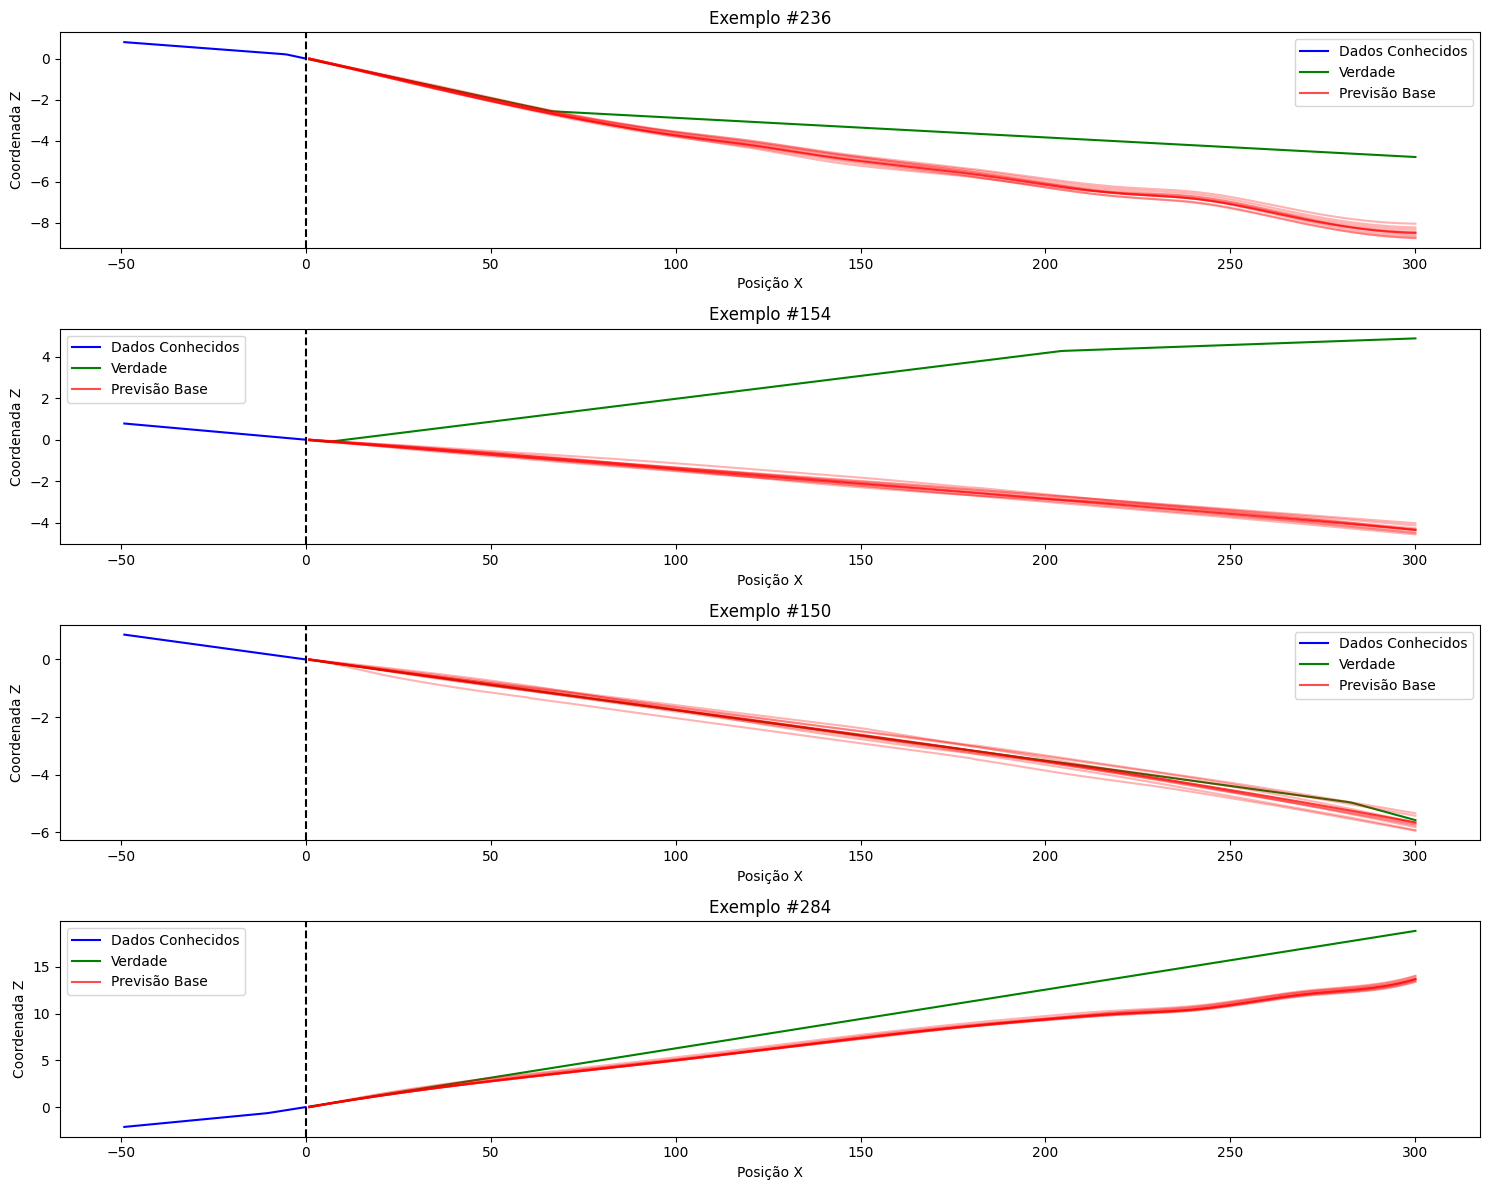

In [8]:
def main():
    train_path = "/kaggle/input/geology-forecast-challenge-open/data/train.csv"
    test_path = "/kaggle/input/geology-forecast-challenge-open/data/test.csv"
    
    try:
        print("=" * 80)
        print("INICIANDO PIPELINE DE PREDIÇÃO DE CAMADAS GEOLÓGICAS")
        print("=" * 80)
        
        train_df, train_ids, input_cols, output_cols, test_df, test_ids = load_data(train_path, test_path)
        
        X_train, X_val, y_train, y_val, n_derived_features = prepare_data(train_df, input_cols, output_cols)
        
        variance_params = analyze_variance_structure(X_train, y_train, n_derived_features)
        
        models, scaler, key_positions, n_derived_features = train_advanced_ensemble_models(
            X_train, y_train, n_derived_features, n_jobs=-1
        )
        
        print("\nGerando previsões base para validação...")
        val_base_predictions = predict_with_advanced_ensemble(X_val, models, scaler, key_positions, n_derived_features)
        
        print("\nGerando realizações para validação...")
        val_realizations = generate_calibrated_realizations(
            X_val, val_base_predictions, variance_params, n_derived_features, NUM_REALIZATIONS
        )
        
        nll_loss = calculate_nll_loss(y_val, val_realizations)
        print(f"\nNegative Log Likelihood (NLL) inicial: {nll_loss}")
        
        best_scale, best_nll = calibrate_nll_target(val_realizations, y_val, initial_value=0.6, target_nll=TARGET_NLL)
        
        segments = [(0, 60), (60, 180), (180, 300)]
        segment_scales = [best_scale * 0.95, best_scale, best_scale * 1.05]
        
        for r in range(1, val_realizations.shape[1]):
            for i in range(val_realizations.shape[0]):
                base = val_base_predictions[i]
                for (start, end), seg_scale in zip(segments, segment_scales):
                    diff = val_realizations[i, r, start:end] - base[start:end]
                    scaled_diff = diff * seg_scale
                    val_realizations[i, r, start:end] = base[start:end] + scaled_diff
        
        visualize_examples(X_val, y_val, val_realizations, n_derived_features, num_examples=4)
        
        print("\nPreparando dados de teste...")
        X_test = test_df[input_cols].values
        
        print("Tratando valores faltantes no conjunto de teste...")
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        X_test_imputed = imputer.fit_transform(X_test)
        
        if np.isnan(X_test_imputed).any() or np.isinf(X_test_imputed).any():
            print("Corrigindo valores NaN/Inf residuais...")
            X_test_imputed = np.nan_to_num(X_test_imputed, nan=0.0, posinf=0.0, neginf=0.0)
        
        print("Criando características derivadas para conjunto de teste...")
        test_derived_features = create_derived_features(X_test_imputed)
        X_test_enhanced = np.hstack((X_test_imputed, test_derived_features))
        
        print("\nGerando previsões base para teste...")
        test_base_predictions = predict_with_advanced_ensemble(
            X_test_enhanced, models, scaler, key_positions, n_derived_features
        )
        
        print("\nGerando realizações para conjunto de teste...")
        test_realizations = generate_calibrated_realizations(
            X_test_enhanced, test_base_predictions, variance_params, n_derived_features, NUM_REALIZATIONS
        )
        
        print(f"\nAplicando escala de variância calibrada segmentada...")
        for r in range(1, NUM_REALIZATIONS):
            for i in range(test_realizations.shape[0]):
                base = test_realizations[i, 0, :]
                for (start, end), seg_scale in zip(segments, segment_scales):
                    diff = test_realizations[i, r, start:end] - base[start:end]
                    scaled_diff = diff * seg_scale
                    test_realizations[i, r, start:end] = base[start:end] + scaled_diff
        
        prepare_submission(test_ids, test_realizations, "submission.csv")
        
        print("\n" + "=" * 80)
        print("PIPELINE DE PREDIÇÃO CONCLUÍDO COM SUCESSO!")
        print(f"NLL calibrado: {best_nll:.2f}")
        print("=" * 80)
        
    except Exception as e:
        print(f"\nERRO: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    start_time = time.time()
    
    try:
        main()
        
        execution_time = time.time() - start_time
        hours, remainder = divmod(execution_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f"\nTempo total de execução: {int(hours)}h {int(minutes)}m {seconds:.2f}s")
        
    except Exception as e:
        print(f"\nUm erro ocorreu durante a execução: {e}")
        
        import traceback
        traceback.print_exc()
        
        execution_time = time.time() - start_time
        print(f"Execução terminada após {execution_time:.2f} segundos")